### Import Python packages


In [1]:
import macrosynergy
import pandas as pd
import numpy as np
import polars as pl
import os

from macrosynergy.panel import view_timelines
from macrosynergy.management.types import QuantamentalDataFrame


### Import Python bindings - `msyrs`


In [2]:
import msyrs

In [3]:
DATA_FOLDER_PATH = "E:/Work/jpmaqs-data"
# DATA_FOLDER_PATH = "C:/Users/PalashTyagi/Code/go-dataquery/jpmaqs-data"
DQ_CLIENT_ID = os.getenv("DQ_CLIENT_ID")
DQ_CLIENT_SECRET = os.getenv("DQ_CLIENT_SECRET")

In [4]:
import time

nb_start_time = time.time()

In [5]:
dfpath = f"{DATA_FOLDER_PATH}/data/ADPEMPL_SA_P1M1ML1/USD_ADPEMPL_SA_P1M1ML1.csv"

starttime = time.time()
ldf: pl.DataFrame = msyrs.qdf.load_qdf(dfpath)
print(f"Time taken to load qdf: {time.time() - starttime}")
ldf.head(5)

Time taken to load qdf: 0.010072469711303711


shape: (5, 7)
┌────────────┬─────┬────────────────────┬───────────┬─────────┬─────────┬─────────┐
│ real_date  ┆ cid ┆ xcat               ┆ value     ┆ grading ┆ eop_lag ┆ mop_lag │
│ ---        ┆ --- ┆ ---                ┆ ---       ┆ ---     ┆ ---     ┆ ---     │
│ date       ┆ str ┆ str                ┆ f64       ┆ f64     ┆ i64     ┆ i64     │
╞════════════╪═════╪════════════════════╪═══════════╪═════════╪═════════╪═════════╡
│ 2010-03-03 ┆ USD ┆ ADPEMPL_SA_P1M1ML1 ┆ -0.173806 ┆ 3.0     ┆ 3       ┆ 33      │
│ 2010-03-04 ┆ USD ┆ ADPEMPL_SA_P1M1ML1 ┆ -0.173806 ┆ 3.0     ┆ 4       ┆ 34      │
│ 2010-03-05 ┆ USD ┆ ADPEMPL_SA_P1M1ML1 ┆ -0.173806 ┆ 3.0     ┆ 5       ┆ 35      │
│ 2010-03-08 ┆ USD ┆ ADPEMPL_SA_P1M1ML1 ┆ -0.173806 ┆ 3.0     ┆ 8       ┆ 38      │
│ 2010-03-09 ┆ USD ┆ ADPEMPL_SA_P1M1ML1 ┆ -0.173806 ┆ 3.0     ┆ 9       ┆ 39      │
└────────────┴─────┴────────────────────┴───────────┴─────────┴─────────┴─────────┘

In [6]:
cids_dm = "AUD.CAD.CHF.EUR.GBP.JPY.NOK.NZD.SEK.USD".split(".")
cids_em = "CLP.COP.CZK.HUF.IDR.ILS.INR.KRW.MXN.PLN.THB.TRY.TWD.ZAR".split(".")
cids = cids_dm + cids_em
cids_dux = list(set(cids) - set(["IDR", "NZD"]))
ecos = (
    "CPIC_SA_P1M1ML12.CPIC_SJA_P3M3ML3AR.CPIC_SJA_P6M6ML6AR.CPIH_SA_P1M1ML12."
    "CPIH_SJA_P3M3ML3AR.CPIH_SJA_P6M6ML6AR.INFTEFF_NSA.INTRGDP_NSA_P1M1ML12_3MMA."
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA.PCREDITGDP_SJA_D1M1ML12.RGDP_SA_P1Q1QL4_20QMA."
    "RYLDIRS02Y_NSA.RYLDIRS05Y_NSA.PCREDITBN_SJA_P1M1ML12".split(".")
)

mkts = (
    "DU02YXR_NSA.DU05YXR_NSA.DU02YXR_VT10.DU05YXR_VT10.EQXR_NSA.EQXR_VT10."
    "FXXR_NSA.FXXR_VT10.FXCRR_NSA.FXTARGETED_NSA.FXUNTRADABLE_NSA".split(".")
)
xcats = ecos + mkts

tickers = [f"{c}_{x}" for c in cids for x in xcats]

In [7]:
starttime = time.time()

big_df: pl.DataFrame = msyrs.qdf.load_qdf_from_download_bank(
    folder_path=DATA_FOLDER_PATH,
    xcats=xcats,
)
print(f"Time taken to load qdf batch: {time.time() - starttime}")


Time taken to load qdf batch: 1.202073335647583


In [8]:
big_df.estimated_size("mb")

286.69339656829834

In [9]:
starttime = time.time()

test_df = msyrs.qdf.reduce_dataframe(df=big_df, xcats=mkts)

print(f"Time taken to reduce qdf: {time.time() - starttime}")
print(test_df.estimated_size("mb"))
test_df = None

Time taken to reduce qdf: 0.9944026470184326
99.33047294616699


In [10]:
sel_cids = ["USD", "EUR", "GBP", "AUD", "CAD", "CHF", "JPY", "INR"]
start = "1990-01-01"

In [11]:
eq_xcats = [xc for xc in xcats if xc.startswith("EQ")]
starttime = time.time()

eq_df = msyrs.qdf.reduce_dataframe(
    df=big_df, cids=sel_cids, xcats=eq_xcats, start=start
)

print(f"Time taken to reduce qdf: {time.time() - starttime}")

Time taken to reduce qdf: 0.32672691345214844


In [12]:
fx_xcats = [xc for xc in xcats if xc.startswith("FX")]

starttime = time.time()

fx_df = msyrs.qdf.reduce_dataframe(
    df=big_df, cids=sel_cids, xcats=fx_xcats, start=start
)
new_df: pl.DataFrame = msyrs.qdf.update_dataframe(df=eq_df, df_add=fx_df)

print(f"Time taken to reduce qdf: {time.time() - starttime}")

Time taken to reduce qdf: 0.4290201663970947


In [13]:
starttime = time.time()

new_df: pl.DataFrame = msyrs.qdf.update_dataframe(df=eq_df, df_add=fx_df)

print(f"Time taken to update qdf: {time.time() - starttime}")

Time taken to update qdf: 0.02323746681213379


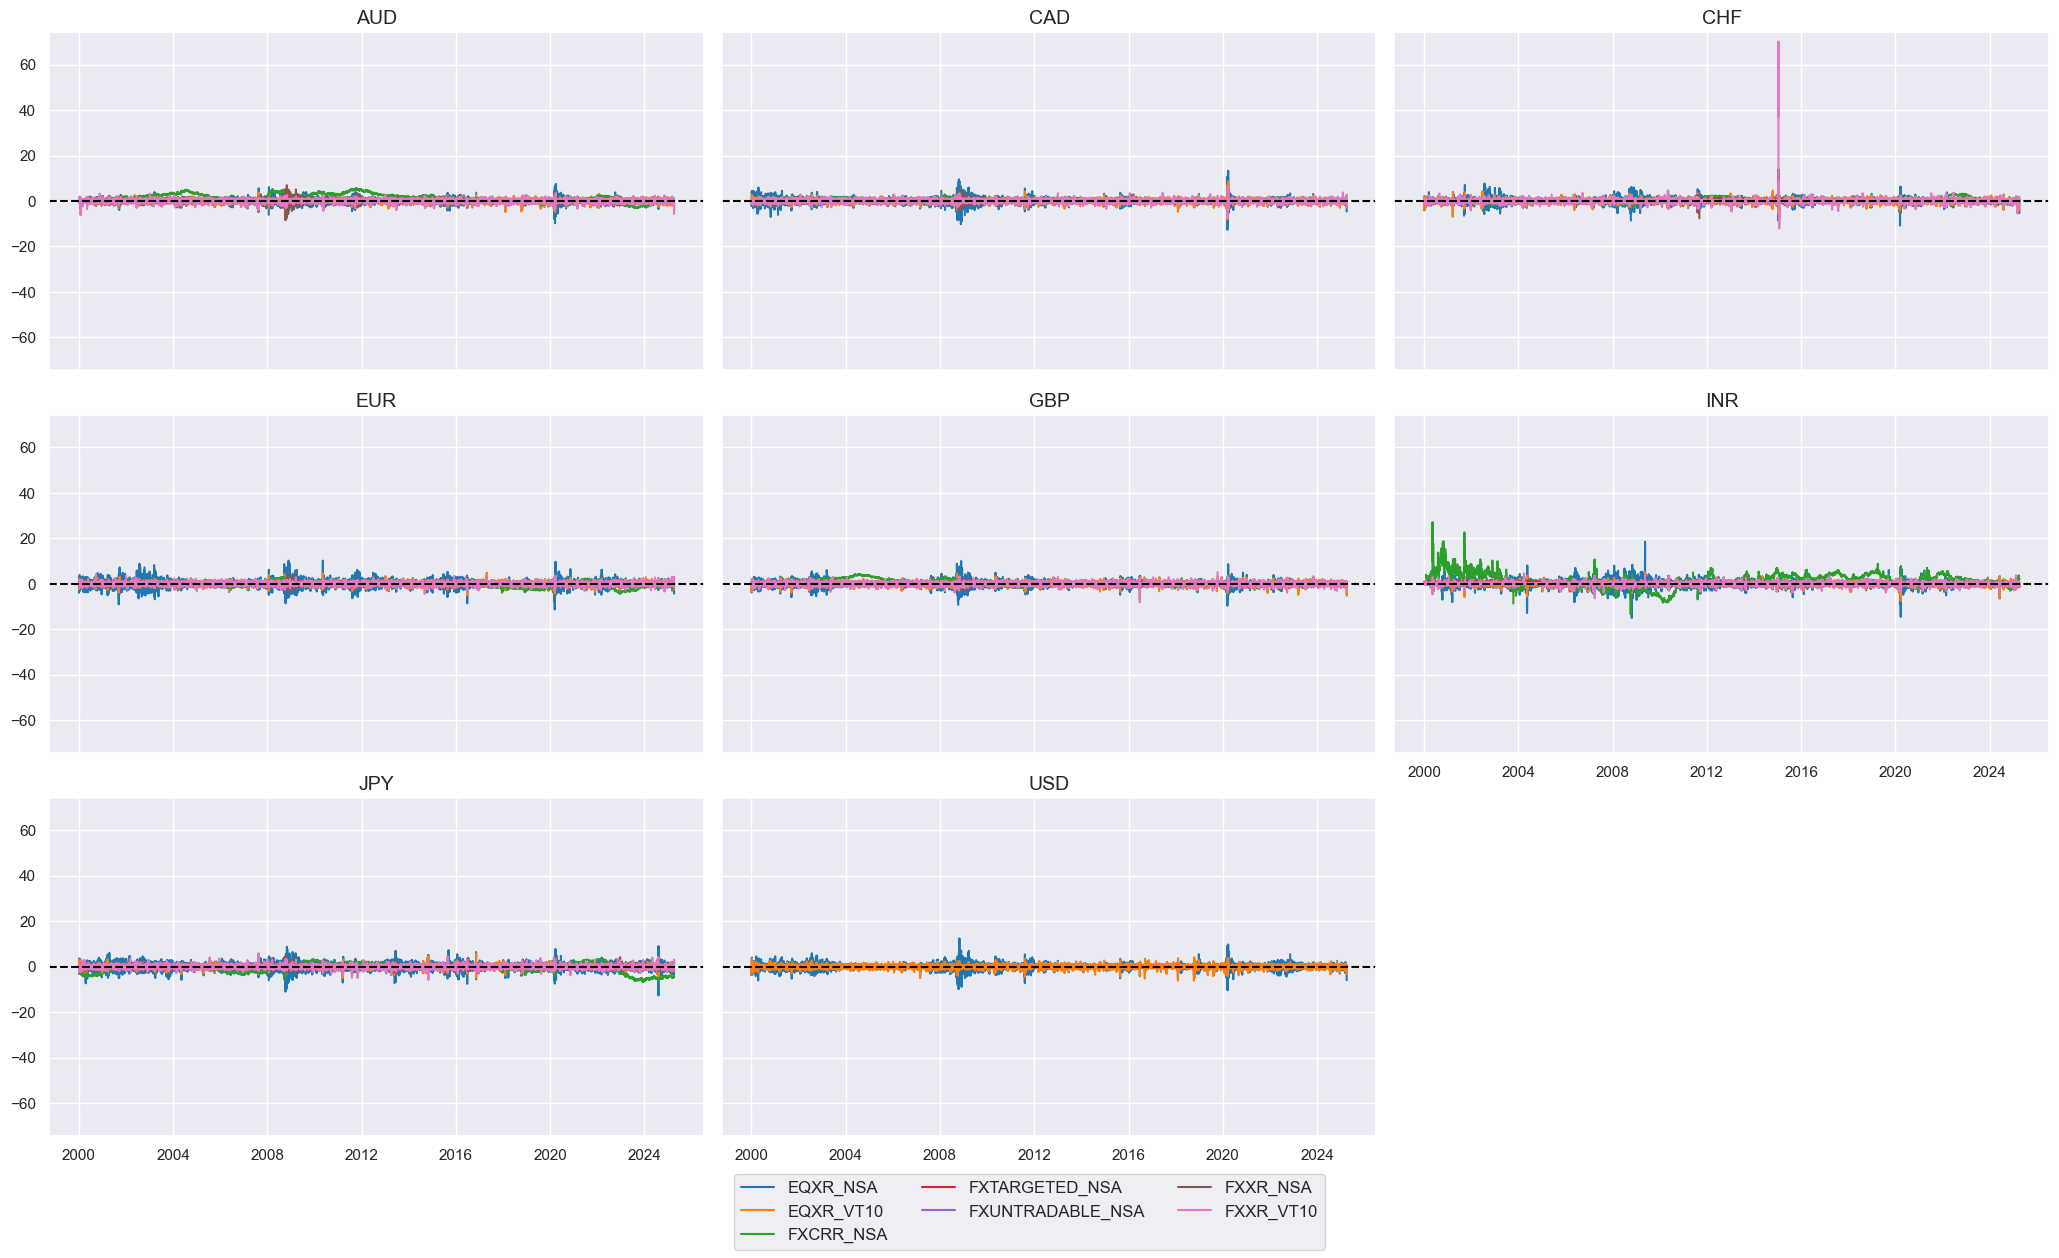

In [14]:
view_timelines(df=new_df.to_pandas())

In [15]:
end_time = time.time()
print(f"Time taken: {end_time - nb_start_time} seconds")

Time taken: 4.3923423290252686 seconds
